<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title data
import torch
import torch.nn as nn
# import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# https://github.com/python-engineer/pytorchTutorial/blob/master/14_cnn.py

# dataset has PILImage images of range [0, 1], transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose(transforms.ToTensor())

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 64 # 4
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader) # get some random training images
images, labels = dataiter.next()
# imshow(torchvision.utils.make_grid(images))


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# @title simplifi
# https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        self.i_downsample = i_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = nn.ReLU()(x)
        return x


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels*self.expansion),
        )
        self.i_downsample = i_downsample
        
    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        if self.i_downsample is not None: #downsample if needed
            identity = self.i_downsample(identity)
        x += identity #add identity
        x = nn.ReLU()(x)
        return x


class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        # https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py
        # num_blocks=[3,3,3] aka layer_list
        plane_list=[64,128,256]
        # plane_list=[16,32,64] #og
        self.in_channels = plane_list[0]
        self.conv = nn.Sequential(
            nn.Conv2d(3, plane_list[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(plane_list[0]), nn.ReLU(),
            self._make_layer(ResBlock, layer_list[0], plane_list[0], stride=1),
            self._make_layer(ResBlock, layer_list[1], plane_list[1], stride=2),
            self._make_layer(ResBlock, layer_list[2], plane_list[2], stride=2),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        # self.fc = nn.Linear(plane_list[2]*ResBlock.expansion, num_classes)
        self.cc = nn.Conv2d(plane_list[2]*ResBlock.expansion, num_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.conv(x)
        # print("forward x",x.shape)
        # x = x.reshape(x.shape[0], -1)
        # x = self.fc(x)
        x = self.cc(x)
        x = torch.squeeze(x)
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
        return nn.Sequential(*layers)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResNet(Bottleneck, [3,4,6,3], num_classes=10, num_channels=3).to(device)
model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)
# print(model)

loss_list=[]


In [ ]:
# @title model

# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         plane_list=[64,128,256,512]
#         self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
#             nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(),# nn.MaxPool2d(2, 2),
#             nn.Conv2d(plane_list[0], plane_list[1], 5, 1, 2), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(plane_list[1], plane_list[2], 7, 1, 3), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
#         )
#         self.linear = nn.Sequential(
#             # nn.Linear(16 * 8 * 8, 256), nn.ReLU(),
#             nn.Linear(plane_list[2] * 8 * 8, 256), nn.ReLU(),
#             # nn.Linear(plane_list[2]//16, 256), nn.ReLU(),
#             nn.Linear(256, 64), nn.ReLU(),
#             nn.Linear(64, 10),
#         )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        plane_list=[64,128,256,512]
        self.conv = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(3, plane_list[0], 3, 1, 1), nn.BatchNorm2d(plane_list[0]), nn.ReLU(), #nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[0], plane_list[1], 3, 1, 1), nn.BatchNorm2d(plane_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(plane_list[1], plane_list[2], 3, 1, 1), nn.BatchNorm2d(plane_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(plane_list[2],64, 1, 1, 0), #nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 10, 1, 1, 0),
        )

    def forward(self, x):
        x = self.conv(x)
        # print("forward x",x.shape)
        # x = x.view(-1, 16 * 5 * 5)
        # x = nn.Flatten()(x)
        # x = self.linear(x)
        x = torch.squeeze(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNet().to(device)
# print(model)

loss_list=[]



In [ ]:
X = torch.rand(64, 3, 32, 32, device=device)
logits = model(X)
print(logits.shape)
# print(logits[0])
# print(logits[0].argmax(1))
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
# print(f"Predicted class: {y_pred}")


forward x torch.Size([64, 256, 8, 8])
torch.Size([64, 10, 8, 8])


In [ ]:
# @title train test function

scaler = torch.cuda.amp.GradScaler()
# for data, label in data_iter:
#    optimizer.zero_grad()
#    # Casts operations to mixed precision
#    with torch.cuda.amp.autocast():
#       loss = model(data)
#    scaler.scale(loss).backward()
#    scaler.step(optimizer)
#    scaler.update()

# def strain(dataloader, model, loss_fn, optimizer):
def strain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    lr_list, loss_list = [], []
    for batch, (x, y) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            pred = model(sx)
            loss = loss_fn(pred, sy)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        if scheduler is not None:
            lr_list.append(optimizer.param_groups[0]["lr"])
            scheduler.step()
            loss_list.append(loss.item())

        # loss.backward()
        # optimizer.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return lr_list, loss_list

# def train(dataloader, model, loss_fn, optimizer):
def train(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
    # for batch, ((x,y), labels) in enumerate(dataloader):
        sx, sy = x.to(device), y.to(device)
        # print("sx sy",sx.shape,sy.shape)
        pred = model(sx)
        loss = loss_fn(pred, sy)
        # loss = model.loss(sx,sy)
        optimizer.zero_grad() # reset gradients of model parameters, to prevent double-counting
        loss.backward() # Backpropagate gradients
        optimizer.step() # adjust the parameters by the gradients
        if scheduler is not None: scheduler.step()
        if (batch) % (size//(10* len(x))) == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# def test(dataloader, model, loss_fn):
def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            x, y = X.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # if verbose: print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if verbose: print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct


In [ ]:
# @title lrfinder

# https://towardsdatascience.com/super-convergence-with-just-pytorch-c223c0fc1e51
# https://github.com/davidtvs/pytorch-lr-finder
# # https://arxiv.org/pdf/1506.01186.pdf
# LR range test
# Note the learning rate value when the accuracy starts to
# increase and when the accuracy slows, becomes ragged, or starts to fall
# _/\

# cyclic
# 0.0001-0.001

# num_iter=20
# start_lr=3e-5
# end_lr= 3e-0
loss_fn = nn.CrossEntropyLoss()
#     model1=copy.deepcopy(model)
#     # for g in optimizer.param_groups: g['lr'] = start_lr
# https://stackoverflow.com/a/55760170
#         lr=optimizer.param_groups[0]["lr"]
#         # lr=scheduler.get_last_lr()[0]

def lrfinder(model1, dataloader, start_lr=1e-5, end_lr=1e1, num_iter=200):
    scaler = torch.cuda.amp.GradScaler()
    acc_list, lr_list, loss_list = [], [], []
    optimizer = torch.optim.AdamW(model1.parameters(), lr=start_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6) #3e-6
    # optimizer = torch.optim.SGD(model1.parameters(), lr=start_lr, momentum=0.9)
    gamma = np.exp(np.log(end_lr/start_lr)/num_iter)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    size = len(dataloader.dataset)
    model.train()
    loader_iter = iter(dataloader)
    for t in range(num_iter):
    # for batch, (x, y) in enumerate(dataloader):
        # if 
            # loader_iter = iter(dataloader)
        x, y = next(loader_iter)
        sx, sy = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            pred = model(sx)
            loss = loss_fn(pred, sy)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # loss.backward()
        # optimizer.step()

        lr=optimizer.param_groups[0]["lr"] # lr=scheduler.get_last_lr()[0]
        lr_list.append(lr); loss_list.append(loss.item())#; acc_list.append(accuracy)
        print("###### iter: ",t,", lr: ",lr,", loss: ",loss.item()) # print("accuracy: ",accuracy)
        scheduler.step()
    return lr_list, loss_list #,acc_list
    # # base_lr ,max_lr


batch_size=512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)

import time
start = time.time()

lr_list, loss_list = lrfinder(model, train_loader, start_lr=1e-8, end_lr=1e0, num_iter=97) #195(256) 97(512)

end = time.time()
print("time: ",end - start)


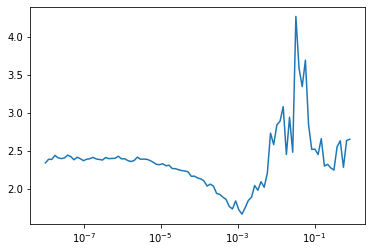

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(lr_list,acc_list)
# plt.plot(acc_list)
plt.plot(lr_list, loss_list)
# plt.plot(lr_list[:-40], loss_list[:-40])
plt.xscale('log')
plt.show()
plt.close()


In [ ]:
#  time epoch
import time
start = time.time()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
strain(train_loader, model, loss_fn, optimizer, verbose=False)

end = time.time()
print("time: ",end - start)


In [ ]:
# @title scheduler

# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR


class _LRScheduler(object):

    def __init__(self, optimizer, last_epoch=-1, verbose=False):

        # Attach optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        # Initialize epoch and base learning rates
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = [group['initial_lr'] for group in optimizer.param_groups]
        self.last_epoch = last_epoch

        # Following https://github.com/pytorch/pytorch/issues/20124
        # We would like to ensure that `lr_scheduler.step()` is called after
        # `optimizer.step()`
        def with_counter(method):
            if getattr(method, '_with_counter', False):
                # `optimizer.step()` has already been replaced, return.
                return method

            # Keep a weak reference to the optimizer instance to prevent
            # cyclic references.
            instance_ref = weakref.ref(method.__self__)
            # Get the unbound method for the same purpose.
            func = method.__func__
            cls = instance_ref().__class__
            del method

            @wraps(func)
            def wrapper(*args, **kwargs):
                instance = instance_ref()
                instance._step_count += 1
                wrapped = func.__get__(instance, cls)
                return wrapped(*args, **kwargs)

            # Note that the returned function here is no longer a bound method,
            # so attributes like `__func__` and `__self__` no longer exist.
            wrapper._with_counter = True
            return wrapper

        self.optimizer.step = with_counter(self.optimizer.step)
        self.verbose = verbose

        self._initial_step()

    def _initial_step(self):
        """Initialize step counts and performs a step"""
        self.optimizer._step_count = 0
        self._step_count = 0
        self.step()

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.

        Args:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_last_lr(self):
        """ Return last computed learning rate by current scheduler.
        """
        return self._last_lr

    def get_lr(self):
        # Compute learning rate using chainable form of the scheduler
        raise NotImplementedError

    def print_lr(self, is_verbose, group, lr, epoch=None):
        """Display the current learning rate.
        """
        if is_verbose:
            if epoch is None:
                print('Adjusting learning rate'
                      ' of group {} to {:.4e}.'.format(group, lr))
            else:
                epoch_str = ("%.2f" if isinstance(epoch, float) else
                             "%.5d") % epoch
                print('Epoch {}: adjusting learning rate'
                      ' of group {} to {:.4e}.'.format(epoch_str, group, lr))


    def step(self, epoch=None):
        # Raise a warning if old pattern is detected
        # https://github.com/pytorch/pytorch/issues/20124
        if self._step_count == 1:
            if not hasattr(self.optimizer.step, "_with_counter"):
                warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
                              "initialization. Please, make sure to call `optimizer.step()` before "
                              "`lr_scheduler.step()`. See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

            # Just check if there were two first lr_scheduler.step() calls before optimizer.step()
            elif self.optimizer._step_count < 1:
                warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
                              "In PyTorch 1.1.0 and later, you should call them in the opposite order: "
                              "`optimizer.step()` before `lr_scheduler.step()`.  Failure to do this "
                              "will result in PyTorch skipping the first value of the learning rate schedule. "
                              "See more details at "
                              "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
        self._step_count += 1

        class _enable_get_lr_call:

            def __init__(self, o):
                self.o = o

            def __enter__(self):
                self.o._get_lr_called_within_step = True
                return self

            def __exit__(self, type, value, traceback):
                self.o._get_lr_called_within_step = False

        with _enable_get_lr_call(self):
            if epoch is None:
                self.last_epoch += 1
                values = self.get_lr()
            else:
                warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
                self.last_epoch = epoch
                if hasattr(self, "_get_closed_form_lr"):
                    values = self._get_closed_form_lr()
                else:
                    values = self.get_lr()

        for i, data in enumerate(zip(self.optimizer.param_groups, values)):
            param_group, lr = data
            param_group['lr'] = lr
            self.print_lr(self.verbose, i, lr, epoch)

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]


class OneCycleLRr(_LRScheduler):
    def __init__(self,
                 optimizer,
                 max_lr,
                 total_steps=None,
                 epochs=None,
                 steps_per_epoch=None,
                 pct_start=0.3,
                 anneal_strategy='cos',
                 cycle_momentum=True,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=25.,
                 final_div_factor=1e4,
                 three_phase=False,
                 last_epoch=-1,
                 verbose=False):

        # Validate optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        # Validate total_steps
        if total_steps is None and epochs is None and steps_per_epoch is None:
            raise ValueError("You must define either total_steps OR (epochs AND steps_per_epoch)")
        elif total_steps is not None:
            if total_steps <= 0 or not isinstance(total_steps, int):
                raise ValueError("Expected positive integer total_steps, but got {}".format(total_steps))
            self.total_steps = total_steps
        else:
            if epochs <= 0 or not isinstance(epochs, int):
                raise ValueError("Expected positive integer epochs, but got {}".format(epochs))
            if steps_per_epoch <= 0 or not isinstance(steps_per_epoch, int):
                raise ValueError("Expected positive integer steps_per_epoch, but got {}".format(steps_per_epoch))
            self.total_steps = epochs * steps_per_epoch

        if three_phase:
            self._schedule_phases = [
                {
                    'end_step': float(pct_start * self.total_steps) - 1,
                    'start_lr': 'initial_lr',
                    'end_lr': 'max_lr',
                    'start_momentum': 'max_momentum',
                    'end_momentum': 'base_momentum',
                },
                {
                    'end_step': float(2 * pct_start * self.total_steps) - 2,
                    'start_lr': 'max_lr',
                    'end_lr': 'initial_lr',
                    'start_momentum': 'base_momentum',
                    'end_momentum': 'max_momentum',
                },
                {
                    'end_step': self.total_steps - 1,
                    'start_lr': 'initial_lr',
                    'end_lr': 'min_lr',
                    'start_momentum': 'max_momentum',
                    'end_momentum': 'max_momentum',
                },
            ]
        else:
            self._schedule_phases = [
                {
                    'end_step': float(pct_start * self.total_steps) - 1,
                    'start_lr': 'initial_lr',
                    'end_lr': 'max_lr',
                    'start_momentum': 'max_momentum',
                    'end_momentum': 'base_momentum',
                },
                {
                    'end_step': self.total_steps - 1,
                    'start_lr': 'max_lr',
                    'end_lr': 'min_lr',
                    'start_momentum': 'base_momentum',
                    'end_momentum': 'max_momentum',
                },
            ]

        # Validate pct_start
        if pct_start < 0 or pct_start > 1 or not isinstance(pct_start, float):
            raise ValueError("Expected float between 0 and 1 pct_start, but got {}".format(pct_start))

        # Validate anneal_strategy
        if anneal_strategy not in ['cos', 'linear']:
            raise ValueError("anneal_strategy must by one of 'cos' or 'linear', instead got {}".format(anneal_strategy))
        elif anneal_strategy == 'cos':
            self.anneal_func = self._annealing_cos
        elif anneal_strategy == 'linear':
            self.anneal_func = self._annealing_linear

        # Initialize learning rate variables
        max_lrs = self._format_param('max_lr', self.optimizer, max_lr)
        if last_epoch == -1:
            for idx, group in enumerate(self.optimizer.param_groups):
                group['initial_lr'] = max_lrs[idx] / div_factor
                group['max_lr'] = max_lrs[idx]
                group['min_lr'] = group['initial_lr'] / final_div_factor

        # Initialize momentum variables
        self.cycle_momentum = cycle_momentum
        if self.cycle_momentum:
            if 'momentum' not in self.optimizer.defaults and 'betas' not in self.optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')
            self.use_beta1 = 'betas' in self.optimizer.defaults
            max_momentums = self._format_param('max_momentum', optimizer, max_momentum)
            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for m_momentum, b_momentum, group in zip(max_momentums, base_momentums, optimizer.param_groups):
                    if self.use_beta1:
                        group['betas'] = (m_momentum, *group['betas'][1:])
                    else:
                        group['momentum'] = m_momentum
                    group['max_momentum'] = m_momentum
                    group['base_momentum'] = b_momentum

        super(OneCycleLR, self).__init__(optimizer, last_epoch, verbose)

    def _format_param(self, name, optimizer, param):
        """Return correctly formatted lr/momentum for each param group."""
        if isinstance(param, (list, tuple)):
            if len(param) != len(optimizer.param_groups):
                raise ValueError("expected {} values for {}, got {}".format(
                    len(optimizer.param_groups), name, len(param)))
            return param
        else:
            return [param] * len(optimizer.param_groups)

    def _annealing_cos(self, start, end, pct):
        "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
        cos_out = math.cos(math.pi * pct) + 1
        return end + (start - end) / 2.0 * cos_out

    def _annealing_linear(self, start, end, pct):
        "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0."
        return (end - start) * pct + start

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        lrs = []
        step_num = self.last_epoch

        if step_num > self.total_steps:
            raise ValueError("Tried to step {} times. The specified number of total steps is {}"
                             .format(step_num + 1, self.total_steps))

        for group in self.optimizer.param_groups:
            start_step = 0
            for i, phase in enumerate(self._schedule_phases):
                end_step = phase['end_step']
                if step_num <= end_step or i == len(self._schedule_phases) - 1:
                    pct = (step_num - start_step) / (end_step - start_step)
                    computed_lr = self.anneal_func(group[phase['start_lr']], group[phase['end_lr']], pct)
                    if self.cycle_momentum:
                        computed_momentum = self.anneal_func(group[phase['start_momentum']], group[phase['end_momentum']], pct)
                    break
                start_step = phase['end_step']

            lrs.append(computed_lr)
            if self.cycle_momentum:
                if self.use_beta1:
                    group['betas'] = (computed_momentum, *group['betas'][1:])
                else:
                    group['momentum'] = computed_momentum

        return lrs




In [ ]:
# @title plot lr
# https://efficientdl.com/faster-deep-learning-in-pytorch-a-guide
# https://pytorch.org/docs/stable/optim.html

# num_batches=int(np.ceil(len(train_dataset)/batch_size))
num_batches=10
print(num_batches)
epochs = 10 #5 20
num_iter= epochs*num_batches #20

base_lr ,max_lr = 3e-5, 3e-4

# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-4/1e-1)/(num_batches*epochs))
# gamma = np.exp(np.log(end_lr/start_lr)/num_iter)
# print("gamma",gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=True,)

# optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, momentum=0.9, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=base_lr)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=10, step_size_down=5, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=base_lr)
# torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# print(optimizer.param_groups[0].keys())
print(optimizer.defaults)
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR

# lr_list=[]
# for x in range(num_iter):
#     scheduler.step()
#     # lr=optimizer.param_groups[0]["lr"]
#     lr_list.append(scheduler.get_last_lr()[0])

# import matplotlib.pyplot as plt
# plt.plot(lr_list)
# # plt.yscale('log')
# plt.show()



10
{'lr': 3e-05, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 3e-06, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False}


In [ ]:
# @title wwwwwwwww
import time
start = time.time()
lr_lst, loss_lst=[],[]
loss_fn = nn.CrossEntropyLoss()

model = ResNet(Bottleneck, [3,3,3], num_classes=10, num_channels=3).to(device)
batch_size = 512 # 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
base_lr, max_lr = 1e-5, 1e-3
end_lr, start_lr = 0.0001,0.1

num_batches=int(np.ceil(len(train_dataset)/batch_size))
# print(num_batches)
epochs = 10 #5 20
# (1e-5/1e-1)=gamma**(num_batches*epochs)
# gamma = np.exp(np.log(1e-3/1e-1)/epochs) # for scheduler step every epoch
gamma = np.exp(np.log(end_lr/start_lr)/(num_batches*epochs)) # for scheduler step every optimizer step
# print(gamma)
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=3e-6)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=num_iter, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=True,)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, steps_per_epoch=num_batches, pct_start=0.45, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=True,)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # 0.75(20)-0.9(100)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    lr=optimizer.param_groups[0]["lr"]
    lr_list.append(lr)
    print(lr)
    # train(train_loader, model, loss_fn, optimizer)
    lr_ls, loss_ls = strain(train_loader, model, loss_fn, optimizer, scheduler)
    # strain(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
    # scheduler.step()
    lr_lst.append(lr_ls); loss_lst.append(loss_ls)
print("Done!")

end = time.time()
print("time: ",end - start)

torch.save(model.state_dict(), "model.pth")

# model = NeuralNetwork().to(device)
# model.load_state_dict(torch.load("model.pth"))


Epoch 1
-------------------------------
3.9999999999999996e-05
loss: 2.486335  [    0/50000]
loss: 2.165511  [ 4608/50000]
loss: 1.952967  [ 9216/50000]
loss: 1.861454  [13824/50000]
loss: 1.805730  [18432/50000]
loss: 1.652891  [23040/50000]
loss: 1.636802  [27648/50000]
loss: 1.519005  [32256/50000]
loss: 1.472714  [36864/50000]
loss: 1.443112  [41472/50000]
loss: 1.402772  [46080/50000]
Accuracy: 44.7%, Avg loss: 1.598970
Epoch 2
-------------------------------
0.0001527886758400849
loss: 1.374696  [    0/50000]
loss: 1.353732  [ 4608/50000]
loss: 1.213977  [ 9216/50000]
loss: 1.286799  [13824/50000]
loss: 1.192356  [18432/50000]
loss: 1.171222  [23040/50000]
loss: 1.145673  [27648/50000]
loss: 1.177003  [32256/50000]
loss: 1.112185  [36864/50000]
loss: 1.088130  [41472/50000]
loss: 1.100788  [46080/50000]
Accuracy: 57.6%, Avg loss: 1.193986
Epoch 3
-------------------------------
0.0004381493475363405
loss: 1.043305  [    0/50000]
loss: 0.966300  [ 4608/50000]
loss: 0.856182  [ 921

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_lst)
# plt.yscale('log')
plt.show()
# plt.plot(lr_lst)
plt.show()

# print(len(lr_lst[0]))
# print(len(loss_lst[0])) 10,98


98
